In [226]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last' #all last

import pandas as pd
import numpy as np
import os, sys, random
sys.path.append('F:\my_documnet_F')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from importlib import reload
plt=reload(plt)
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import datetime
import seaborn as sns
from scipy import sparse
# import mglearn

import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import lightgbm as lgb

#Auto reloads notebook when changes are made
%reload_ext autoreload
%autoreload 2
import matplotlib.ticker as ticker

import imp
import Library.Rawdata_stack as rawstack
imp.reload(rawstack)

<module 'Library.Rawdata_stack' from 'F:\\my_documnet_F\\Library\\Rawdata_stack.py'>

In [152]:
path = './data/titanic'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_submission = pd.read_csv(path + 'submission.csv')

np.random.seed(1234)
random.seed(1234)

<AxesSubplot:xlabel='Embarked'>

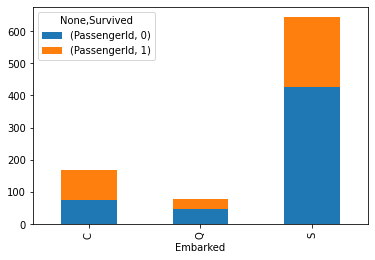

In [153]:
df_embarked = df_train[['Embarked', 'Survived', 'PassengerId']].dropna().groupby(['Embarked', 'Survived']).count().unstack()
df_embarked.plot.bar(stacked = True)

<AxesSubplot:xlabel='Sex'>

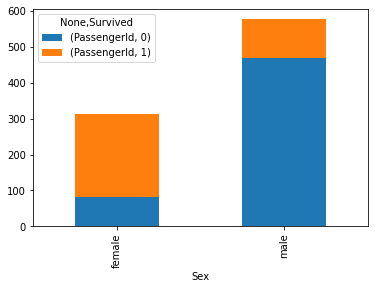

In [154]:
df_sex = df_train[['Sex', 'Survived', 'PassengerId']].dropna().groupby(['Sex', 'Survived']).count().unstack()
df_sex.plot.bar(stacked = True)

<AxesSubplot:xlabel='Pclass'>

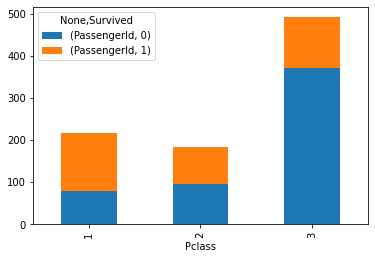

In [155]:
df_class = df_train[['Pclass', 'Survived', 'PassengerId']].dropna().groupby(['Pclass', 'Survived']).count().unstack()
df_class.plot.bar(stacked = True)

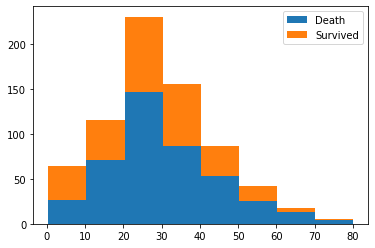

In [156]:
plt.hist(x=[df_train['Age'][df_train.Survived == 0], df_train['Age'][df_train.Survived == 1]], bins = 8, histtype = 'barstacked', label = ['Death', 'Survived'])
plt.legend()

In [157]:
df_train_corr = pd.get_dummies(df_train, columns = ['Sex'], drop_first = True)
df_train_corr = pd.get_dummies(df_train_corr, columns = ['Embarked'])

In [158]:
train_corr = df_train_corr.corr()

<AxesSubplot:>

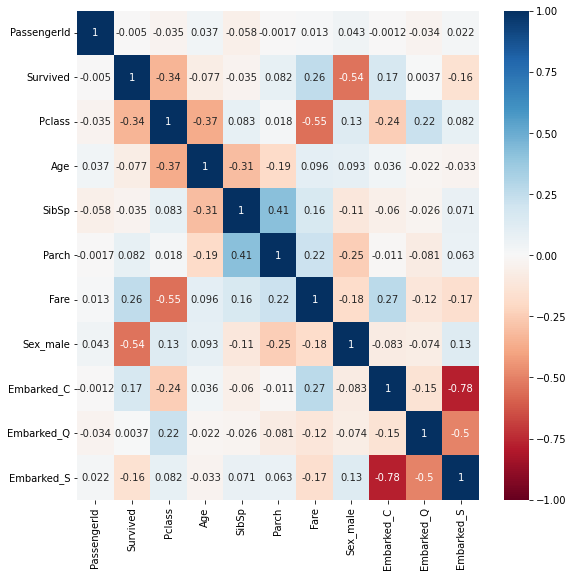

In [159]:
plt.figure(figsize = (9, 9))
sns.heatmap(train_corr, vmax = 1, vmin = -1, center = 0, annot=True, cmap ='RdBu')

In [198]:
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
df_all.loc[df_all.Fare.isnull(), 'Fare'] = df_all[['Pclass', 'Fare']].groupby('Pclass').transform(np.mean)
df_all1 = pd.concat([df_all, df_all['Name'].str.split("[.,]", 2, expand = True).rename(columns = {0:'family_name', 1:'honorific', 2:'name'})], axis = 1)
df_all1.loc[df_all1.Age.isnull(), 'Age'] = df_all1[['honorific', 'Age']].groupby('honorific').transform(np.mean)

df_all1['honorific'] = df_all1['honorific'].str.strip()

<AxesSubplot:xlabel='honorific', ylabel='Age'>

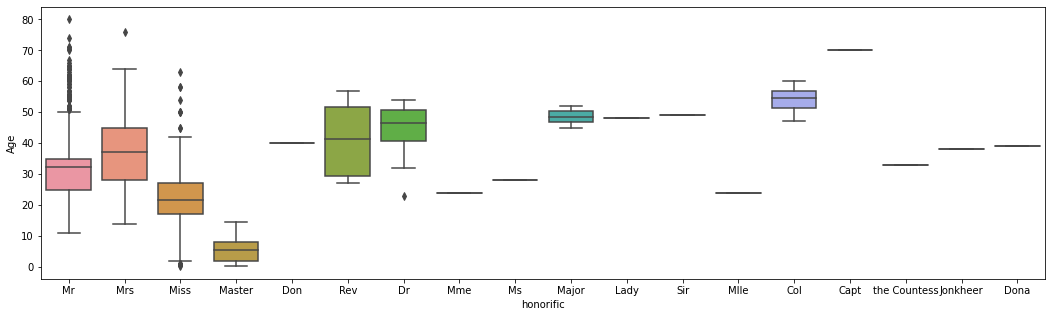

In [199]:
plt.figure(figsize=(18, 5))
sns.boxplot(x='honorific', y='Age', data = df_all1)

In [200]:
df_train1 = df_all1.iloc[:len(df_train), :]
df_test1 = df_all1.iloc[len(df_train):, :]

In [201]:
df_all1['family_num'] = df_all.Parch + df_all.SibSp

df_all1.loc[df_all1.family_num ==0, 'alone'] = 1
df_all1.alone.fillna(0, inplace = True)

<AxesSubplot:xlabel='honorific'>

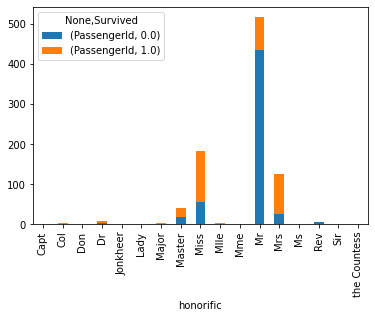

In [202]:
df_train1[['honorific', 'Survived', 'PassengerId']].dropna().groupby(['honorific', 'Survived']).count().unstack().plot.bar(stacked=True)

In [205]:
df_all1.loc[df_all.Age.isnull(), 'Age'] = df_all1[['honorific', 'Age']].groupby('honorific').transform(np.mean)
df_all1.drop(['PassengerId', 'Name', 'family_name', 'name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df_all1.loc[~(df_all1['honorific'].isin(['Mr', 'Miss', 'Mrs', 'Master'])), 'honorific'] = 'others'

In [208]:
df_all1['Embarked'].fillna('missing', inplace = True)

In [220]:
for cat in df_all1.columns[df_all1.dtypes == 'object']:
    le = LabelEncoder()
    if df_all1[cat].dtypes == 'object':
        le = le.fit(df_all1[cat])
        df_all1[cat] = le.transform(df_all1[cat])

In [222]:
X_train = df_all1[~df_all1.Survived.isnull()].drop('Survived', axis = 1).reset_index(drop=True)
Y_train = df_all1[~df_all1.Survived.isnull()]['Survived']

# Making test set

In [229]:
X_test = df_all1[df_all1.Survived.isnull()].drop('Survived', axis = 1).reset_index(drop=True)
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train, Y_train, test_size = 0.2)
categories = ['Embarked', 'Pclass', 'Sex', 'honorific', 'alone']

# Light GBM Method

In [234]:
lgb_train = lgb.Dataset(X_train1, y_train1, categorical_feature = categories)
lgb_eval = lgb.Dataset(X_valid1, y_valid1, categorical_feature = categories, reference = lgb_train)

lgbm_params = {
    'objective' : 'binary',
    'random_seed':1234,
}

model_lgb = lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets = lgb_eval,
                      num_boost_round = 100,
                      early_stopping_rounds = 20,
                      verbose_eval = 10)

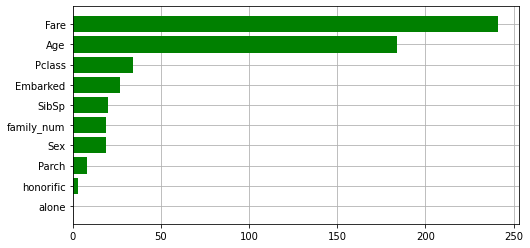

In [260]:
df_impor = pd.DataFrame(model_lgb.feature_importance(), index=X_train1.columns, columns=['importance']).sort_values(by='importance', ascending=True)

plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots()
plt.barh(df_impor.index, df_impor.importance, color = 'g')
ax.set_axisbelow(True)
plt.grid(True)

In [264]:
y_pred = model_lgb.predict(X_valid1, num_iteration=model_lgb.best_iteration)
accuracy_score(y_valid1, np.round(y_pred))

# Linear Regression

In [267]:
rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth = 5, oob_score = True, random_state = 10)
lr = LogisticRegression(random_state = 0)
lr.fit(X_train1, y_train1)
y_pred = lr.predict(X_valid1)
y_pre_prob = lr.predict_proba(X_valid1)[:, 1]

accuracy_score(y_pred, y_valid1)

C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8435754189944135

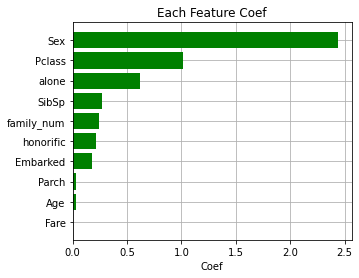

In [279]:
cols = X_train1.columns.tolist()
y_pos = np.arange(len(cols))
df_impor1 = pd.DataFrame(abs(lr.coef_[0]), index=cols, columns=['lr']).sort_values(by='lr', ascending=True)

plt.rcParams['figure.figsize'] = [5,4]
fig, ax = plt.subplots()
ax.barh(df_impor1.index, df_impor1.lr, align = 'center', color = 'g', ecolor = 'k')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_impor1.index)
ax.set_xlabel('Coef')
ax.set_title('Each Feature Coef')
ax.set_axisbelow(True)
plt.grid(True)
plt.show()

# Cross Validation with K Fold

In [283]:
folds = 3
kf = KFold(n_splits = folds)

models = []

In [289]:
for train_index, val_index in kf.split(X_train):
    # print(val_index)
    X_train2 = X_train.iloc[train_index]
    X_valid2 = X_train.iloc[val_index]
    y_train2 = Y_train.iloc[train_index]
    y_valid2 = Y_train.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train2, y_train2, categorical_feature = categories)
    lgb_eval = lgb.Dataset(X_valid2, y_valid2, categorical_feature = categories, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round = 100,
                          early_stopping_rounds = 20,
                          verbose_eval =10,
                         )
    y_pred = model_lgb.predict(X_valid2, num_iteration = model_lgb.best_iteration)
    print(accuracy_score(y_valid2, np.round(y_pred)))
    models.append(model_lgb)

C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Use

[LightGBM] [Info] Number of positive: 236, number of negative: 358
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397306 -> initscore=-0.416701
[LightGBM] [Info] Start training from score -0.416701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [293]:
preds = []

for model in models:
    pred = model.predict(X_valid2)
    preds.append(pred)

In [296]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis = 0)

In [297]:
preds_int = (preds_mean > 0.5).astype(int)

# # of persons each ticket class

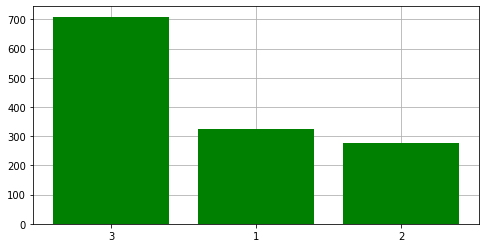

In [314]:
plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots()
plt.bar(df_all.Pclass.value_counts().index.astype(str), df_all.Pclass.value_counts(), color = 'g')
ax.set_axisbelow(True)
plt.grid(True)

# Personal class distribution

In [315]:
df_all1['Pclass2'] = df_all1['Pclass']
df_all1.loc[df_all1.Fare > 108, 'Pclass2'] = 0

In [318]:
df_all1[df_all1.Age > 15][['Pclass2', 'Age']].groupby('Pclass2').describe()

Age                                                              
         count       mean        std   min        25%   50%        75%   max
Pclass2                                                                     
0         74.0  37.523875  13.125761  17.0  27.250000  36.0  46.500000  67.0
1        241.0  39.771071  13.040743  16.0  31.000000  37.0  49.000000  80.0
2        249.0  32.296468  11.035503  16.0  24.000000  30.0  36.994118  70.0
3        622.0  28.826508   8.440935  16.0  21.774238  29.0  32.252151  74.0

C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


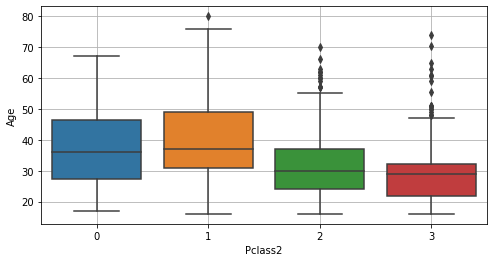

In [319]:
plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots()
sns.boxplot('Pclass2', 'Age', data = df_all1[df_all1.Age > 15][['Pclass2', 'Age']])
ax.set_axisbelow(True)
plt.grid(True)

# age and fare distribution

C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


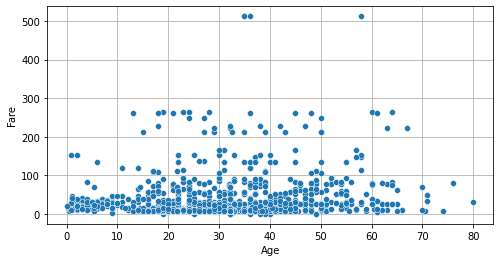

In [320]:
plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots()
sns.scatterplot('Age', 'Fare', data = df_all1[['Age', 'Fare']])
ax.set_axisbelow(True)
plt.grid(True)

# # of family per ticket class

In [322]:
df_all1[['Pclass2', 'family_num']].groupby('Pclass2').describe()

family_num                                              
             count      mean       std  min  25%  50%  75%   max
Pclass2                                                         
0             81.0  1.543210  1.541504  0.0  0.0  1.0  2.0   5.0
1            242.0  0.553719  0.687172  0.0  0.0  0.0  1.0   3.0
2            277.0  0.761733  1.029060  0.0  0.0  0.0  1.0   5.0
3            709.0  0.968970  1.921230  0.0  0.0  0.0  1.0  10.0

C:\Users\Chulwoong Oh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


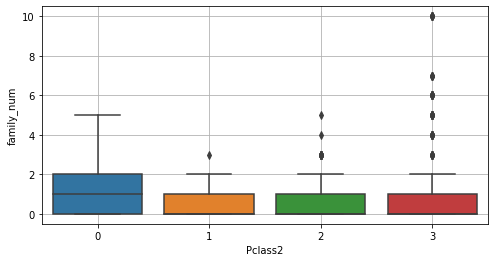

In [323]:
plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots()
sns.boxplot('Pclass2', 'family_num', data = df_all1[['Pclass2', 'family_num']])
ax.set_axisbelow(True)
plt.grid(True)

# ratio of gender per ticket class

In [329]:
df_Pclass_gender = df_all1[['Pclass2', 'Sex', 'Fare']].groupby(['Pclass2', 'Sex']).count().unstack()

In [350]:
df_Pclass_gender

Fare     
Sex        0    1
Pclass2          
0         51   30
1         93  149
2        106  171
3        216  493

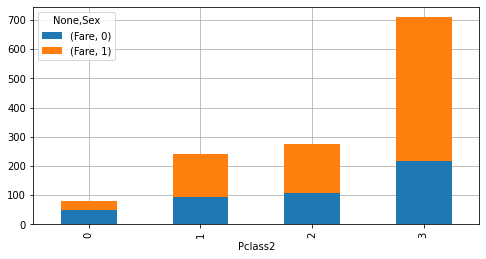

In [349]:
# plt.rcParams['figure.figsize'] = [8,4]
# fig, ax = plt.subplots()
ax = df_Pclass_gender.plot.bar(stacked=True)
ax.set_axisbelow(True)
plt.grid(True)